# Estimate time constants

_Date: 2024-01-13_

In this notebook, we estimate the time constants of syllable label dynamics within a session.
Our goal is to identify a time bin window width that is
- small enough to capture the fastest rates of behavioral syllable (and by proxy, behavioral topic) change, and 
- large enough to provide sufficient observations and statistical power.

We computed and inspected the cross-correlation, power spectrum density, and mixing time constants of the system.
Overall, the estimates appeared to be biased and high-variance.
However, we can say with some confidence that the syllable dynamics are _not_ at frame rate.

The power spectral density analysis suggests that the modal correlation across all sessions and syllables is 128 frames (4.3s).
Inspection of the raw syllable sequences and their calculated cross-correlations suggests that a fair amount of dynamics occur over longer timescales as well.

We may be better off motivating the bin width size from the statistical power perspective.

In [1]:
import jax

from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import numpy as np
import scipy as sp


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

**Load data**

In [3]:
# Load data
filepath = DATASET_DIR + "syllable_sequence_data.npz"

data = {}
with np.load(filepath) as f:
    for key in list(f):
        print(f"{key}:\tshape={f[key].shape}, dtype={f[key].dtype}")
        data[key] = f[key]


session_syllables:	shape=(501, 36000), dtype=uint8
session_drug_name:	shape=(501,), dtype=<U4
session_drug_class:	shape=(501,), dtype=<U14
session_drug_dose_0to6:	shape=(501,), dtype=uint8
perm_syllable_id:	shape=(90,), dtype=uint8
perm_syllable_cluster:	shape=(90,), dtype=<U8


**Helper plotting functions**

In [4]:
# Get unique cluster names (sorted alphanumerically), their first index in
# the dataset, and number of instances per cluster.
cluster_names, cluster_idxs, cluster_counts \
    = np.unique(data['perm_syllable_cluster'], return_index=True, return_counts=True)

# Sort cluster names and counts in the order that they were seen
cluster_idxs = np.argsort(cluster_idxs)
cluster_names = [str(cluster_names[i]) for i in cluster_idxs]
cluster_counts = np.array([cluster_counts[i] for i in cluster_idxs])

# Set bounding edges and label tick location
cluster_edges = np.cumsum(cluster_counts)
cluster_ticks = np.cumsum(cluster_counts) - cluster_counts/2

def set_syllable_cluster_ticks(ax, axis='x', label=True, fontsize='xx-small'):
    """Set syllable cluster ticks and tick labels.
    
    Parameters
        ax (mpl.axes.Axes): Axes to label
        label (bool): If true, label ticks. Else, just draw boundaries.

    """

    if axis == 'x':
        # Break long cluster names into two lines
        labels = [lbl.replace(" ", "\n") for lbl in cluster_names]

        # Set boundary ticks; extend tick length
        ax.set_xticks(cluster_edges[:-1]-0.5, minor=True)
        ax.tick_params(axis='x', which='minor', length=18)

        # Set labels
        if label:
            ax.set_xticks(cluster_ticks)
            ax.set_xticklabels(labels, ha='center', va='center', fontsize=fontsize)
            
            # Hide label tick, add padding from axis
            ax.tick_params(axis='x', which='major', length=0, pad=10)
    
    elif axis == 'y':
        # Keep cluster names in a single line
        labels = cluster_names

        # Set boundary ticks; extend tick length
        ax.set_yticks(cluster_edges[:-1]-0.5, minor=True)
        ax.tick_params(axis='y', which='minor', length=18)

        # Set labels
        if label:
            ax.set_yticks(cluster_ticks)
            ax.set_yticklabels(labels, ha='right', va='center', fontsize=fontsize)
            # Hide label tick, add padding from axis
            ax.tick_params(axis='y', which='major', length=0, pad=5)

    else:
        print(f"WARNING: axis {axis} not recognized. Expected one of 'x' or 'y'.")
    
    return

In [5]:
def set_session_time_ticks(ax, period=1, label=True, axis='x', fontsize='xx-small'):
    """Set within-session time ticks and tick labels.
    
    Parameters
        period (float): Time between ticks, in units of minutes.
        label (bool): If True, label ticks.
    """

    length = 20
    fps = 30

    length_fps = length * 60 * fps
    period_fps = period * 60 * fps

    # Include end of session length
    ticks = np.arange(0, length_fps+1, period_fps)
    tick_labels = np.arange(0, length+1, period)

    if axis == 'x':
        ax.set_xticks(ticks)
        if label:
            ax.set_xticklabels(tick_labels, fontsize=fontsize)

        
    elif axis == 'y':
        ax.set_yticks(ticks)
        if label:
            ax.set_yticklabels(tick_labels, fontsize=fontsize)

    else:
        print(f"WARNING: axis {axis} not recognized. Expected one of 'x' or 'y'.")
    
    return

## 1. Setting bin width based on autocorrelation

In [ ]:
session_syllables = data['session_syllables']
perm_syllable_id = data['perm_syllable_id']
session_names = [
    f"{drug}-{dose}"
    for drug, dose in zip(data["session_drug_name"], data["session_drug_dose_0to6"])
]

n_sessions = len(session_syllables)
n_syllables = 90  # Not including the truncated syllables that will be ignroed

In [ ]:
onehot = lambda seq, dim: jnp.eye(dim)[seq]

onehot_syllables = vmap(onehot, in_axes=(0, None))(session_syllables, n_syllables+1)[...,:-1]
onehot_syllables = onehot_syllables[..., data['perm_syllable_id']]
onehot_syllables.shape

### 1a. Visual inspection

First, let's visually inspect the raw syllable sequence data to get a qualitative sense of the autocorrelation present in the data.

Text(0.5, 0, 'time [minutes]')

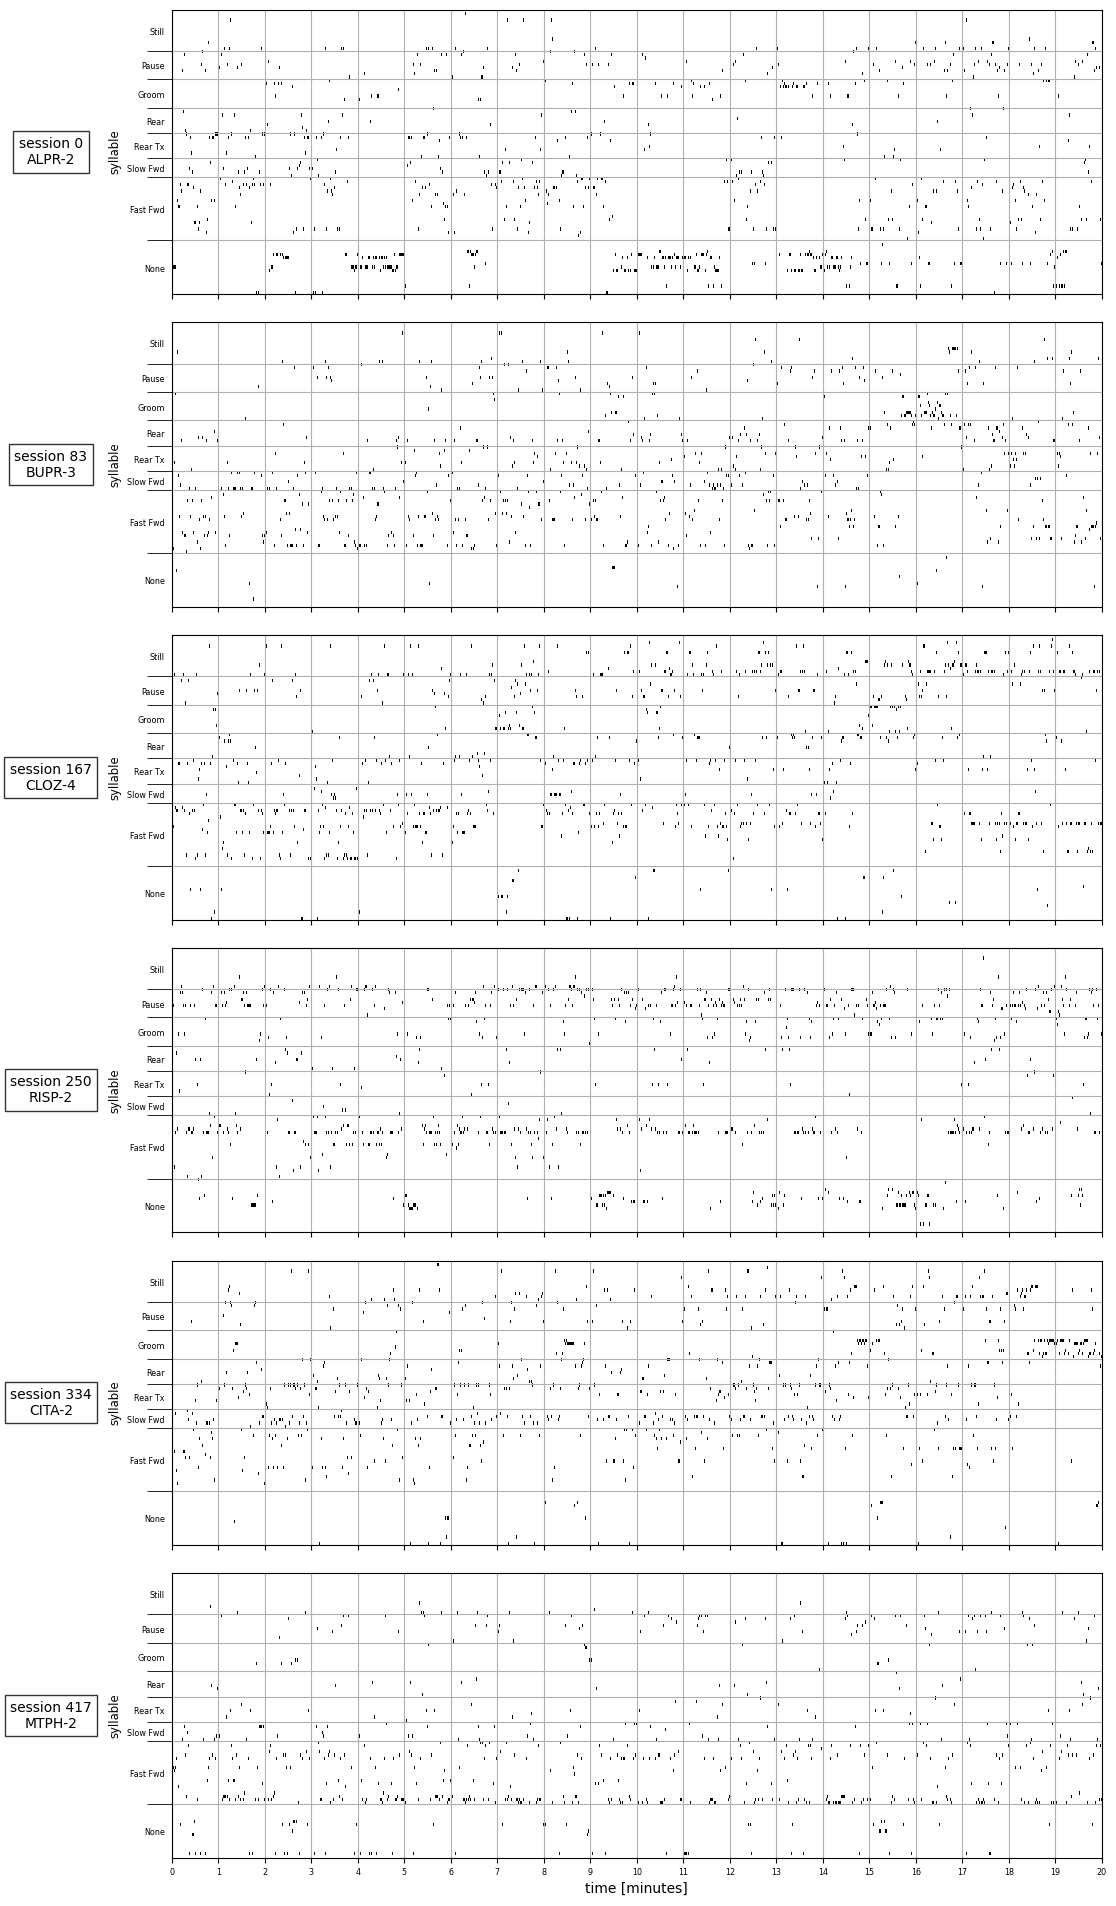

In [7]:
n_examples = 6
selected_sessions = np.linspace(0, n_sessions, num=n_examples, endpoint=False, dtype=int)

fig, axs = plt.subplots(
    nrows=n_examples, ncols=1, sharex=True, sharey=True, figsize=(12,24),
    gridspec_kw={'hspace': 0.1}
)

for ax, i_session in zip(axs, selected_sessions):
    ax.imshow(onehot_syllables[i_sessopm].T, cmap='binary', interpolation='none', aspect='auto')

    set_syllable_cluster_ticks(ax, axis='y')
    ax.set_ylabel('syllable', fontsize='small')

    set_session_time_ticks(ax, axis='x')
    ax.grid(axis='x')
    ax.grid(axis='y', which='minor')

    ax.text(
        -0.13, 0.5,
        f"session {i_session}\n{session_names[i_session]}",
        transform=ax.transAxes,
        ha='center', va='center', fontsize='medium',
        bbox=dict(facecolor='none', edgecolor='0.2')
    )

axs[-1].set_xlabel("time [minutes]")

There are definitely instgances of strong autocorrelation, and other instances of less autocorrelation. This also appears to be somewhat treatment-depedent (e.g. methamphetamine induces very steotyped behaviors)

### 1b. Cross-correlation

In [10]:
# Random select n sessions per drug
_, idxs, n_per_drug = np.unique(data['session_drug_name'], return_index=True, return_counts=True)
n_per_drug = jnp.array([n_per_drug[i] for i in np.argsort(idxs)])
idxs = jnp.sort(idxs)

**Plot session-specific cross-correlation**

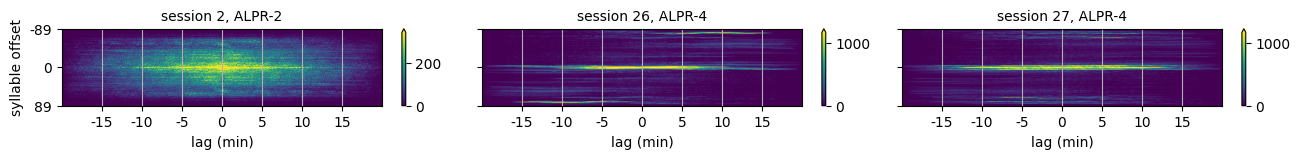

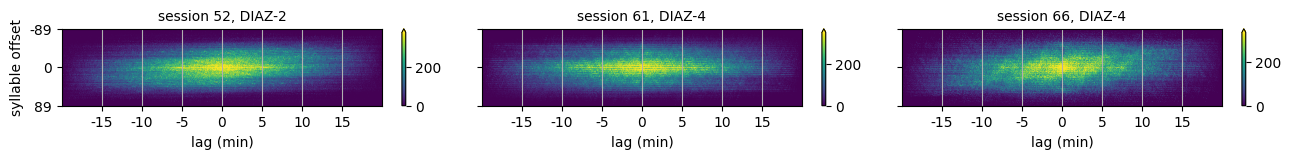

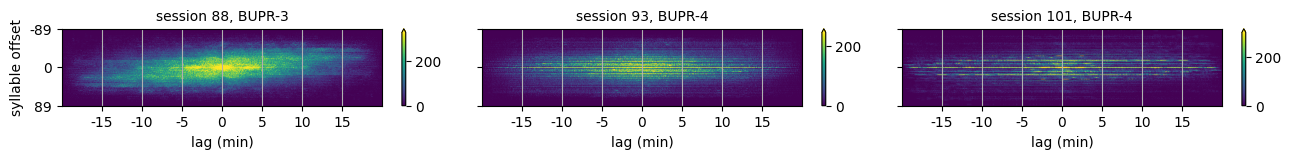

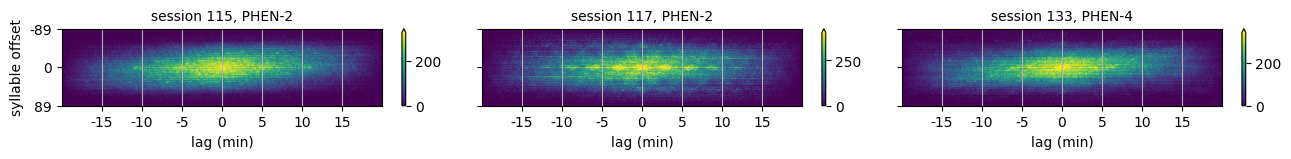

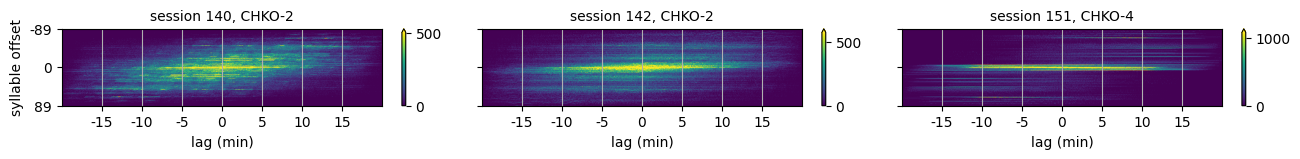

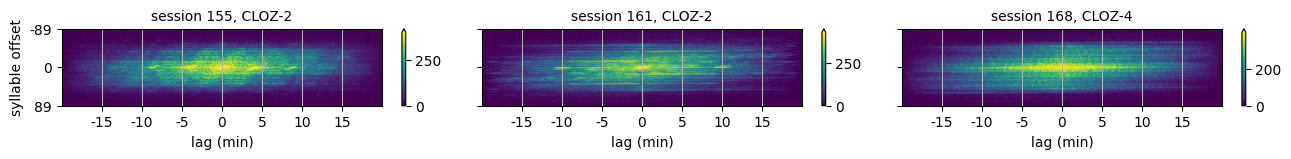

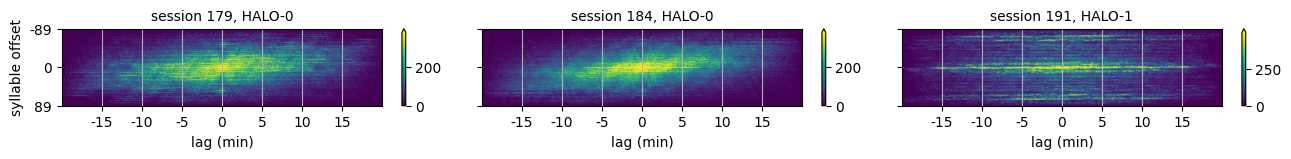

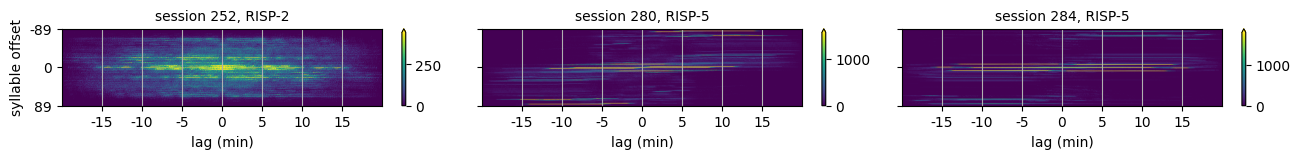

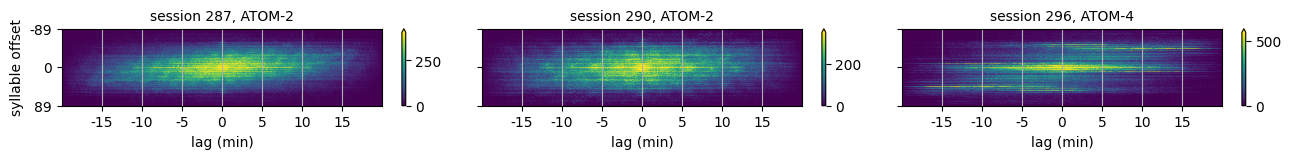

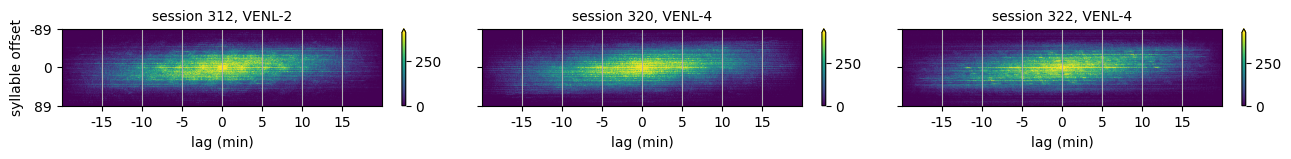

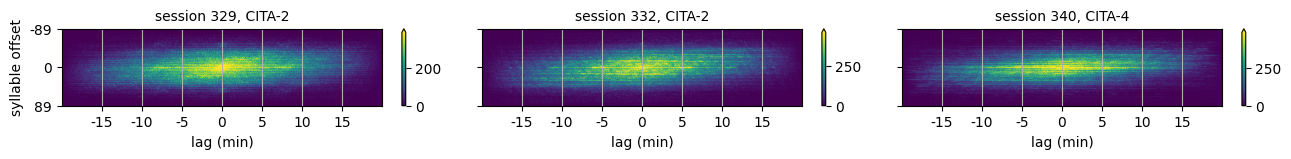

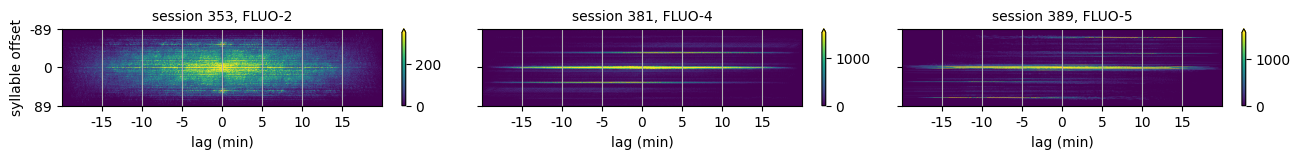

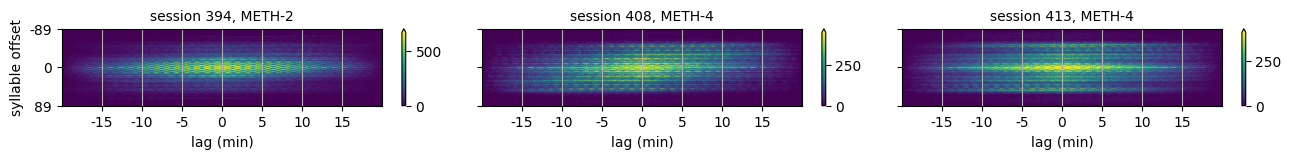

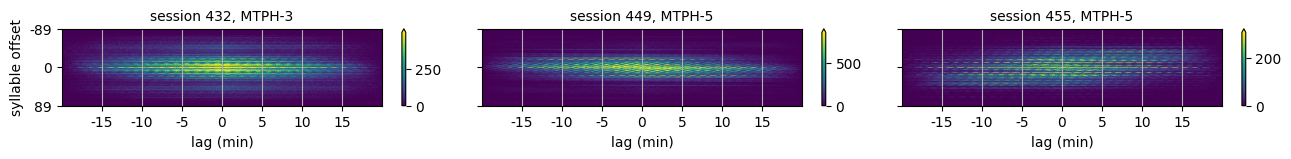

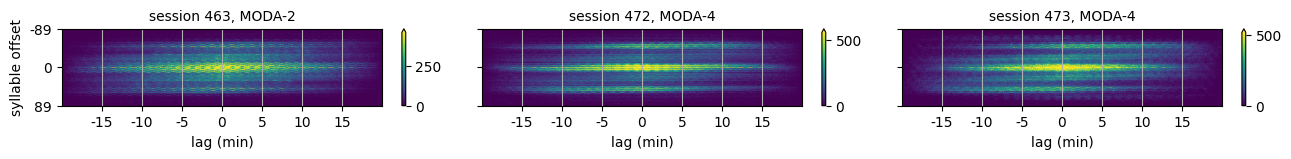

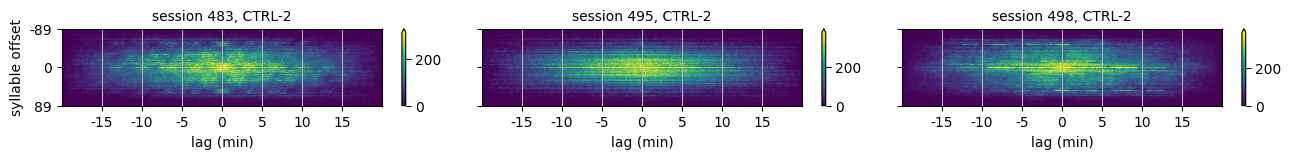

In [129]:
lag_size_min = 5
lag_size_fps = lag_size_min * 60 * 30  # x-axis tick freqeucny

n_examples_per_drug = 3
for start_idx, this_n in zip(idxs, n_per_drug):
    this_key = jr.fold_in(jr.key(0), start_idx)
    selected_sessions = jr.choice(
        this_key, this_n, shape=(n_examples_per_drug,), replace=False,
    )
    selected_sessions = jnp.sort(selected_sessions)
    selected_sessions += start_idx

    fig, axs = plt.subplots(
        ncols=n_examples_per_drug, sharey=True,
        gridspec_kw={'wspace': 0.05},
        figsize=(16,1),
    )

    for ax, i_session in zip(axs, selected_sessions):
        corr = sp.signal.correlate(onehot_syllables[i_session,:-1], onehot_syllables[i_session,1:])

        mat = corr

        vmax = np.percentile(mat, 99)
        im = ax.imshow(mat.T, aspect='auto', vmin=0, vmax=vmax)
        plt.colorbar(im, ax=ax, extend='max')

        # x-axis
        signal_length = (len(mat) + 1) / 2  # single signal length

        lags_fps = np.arange(0, signal_length, lag_size_fps)
        lags_fps = np.asarray(np.concatenate([-lags_fps[::-1], lags_fps[1:]]), dtype=int)

        xticklabels = [f"{int(lag/60/30)}" for lag in lags_fps]
        xticks = signal_length + lags_fps

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel ('lag (min)');
        ax.grid(axis='x')

        # y-axis
        yticklabels = np.array([-(n_syllables-1), 0, n_syllables-1])
        yticks = yticklabels + n_syllables-1

        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_title(f"session {i_session}, {session_names[i_session]}", fontsize='medium')

    axs[0].set_ylabel ('syllable offset');
    plt.show()

### 1c. Power spectral density

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


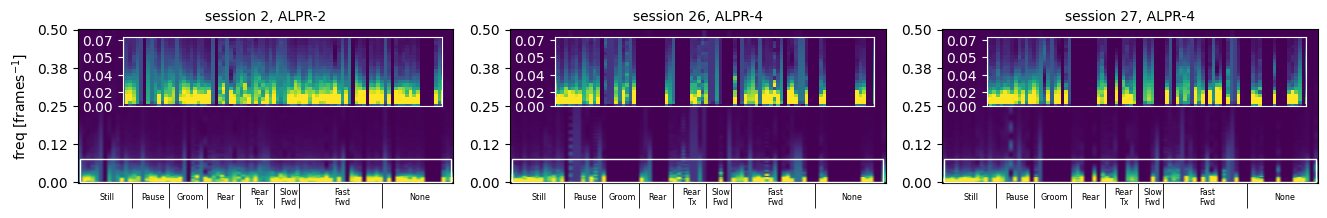

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


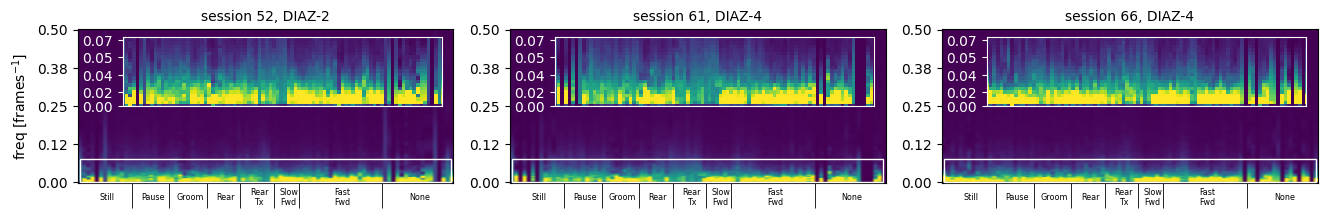

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


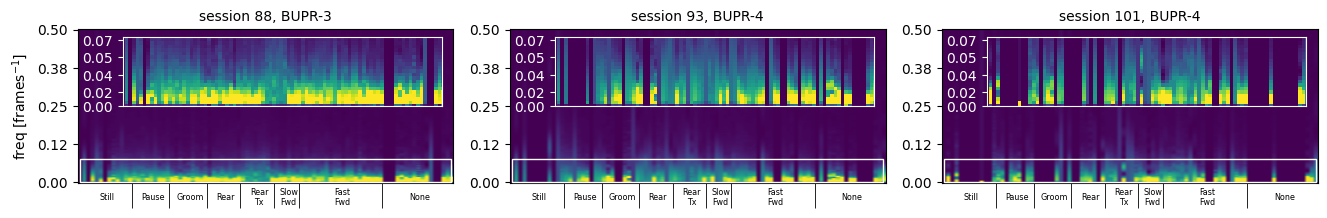

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


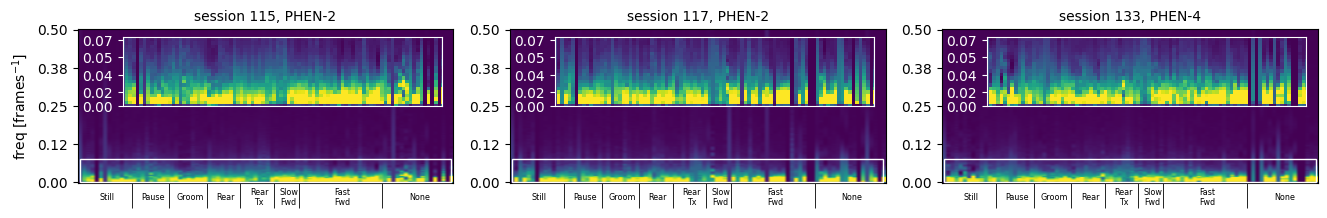

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


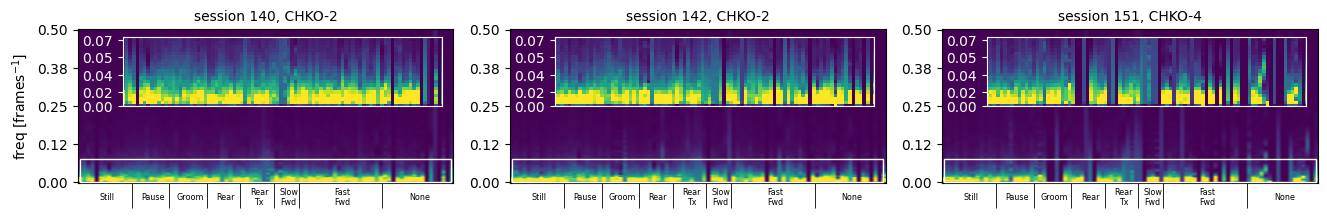

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


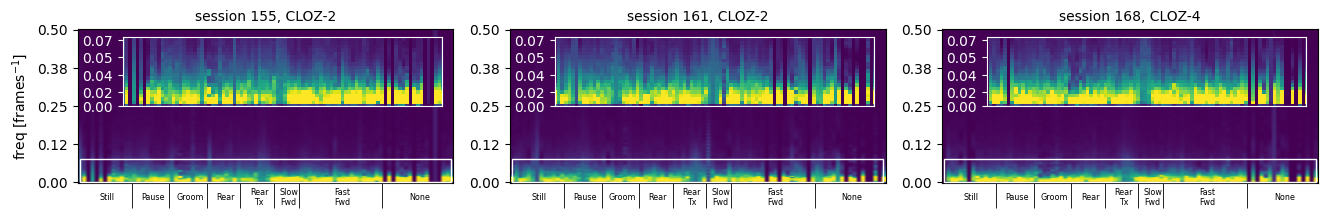

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


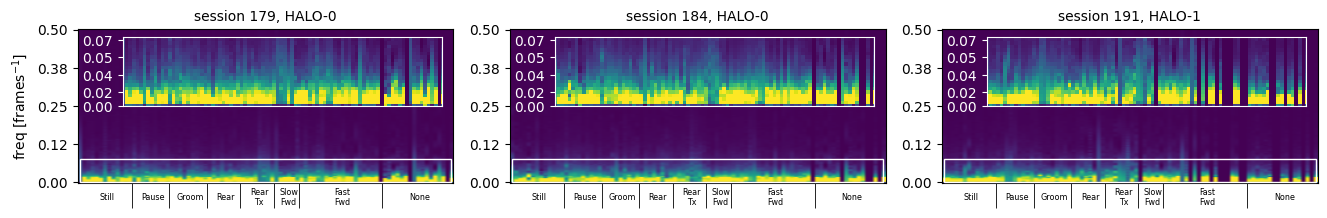

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


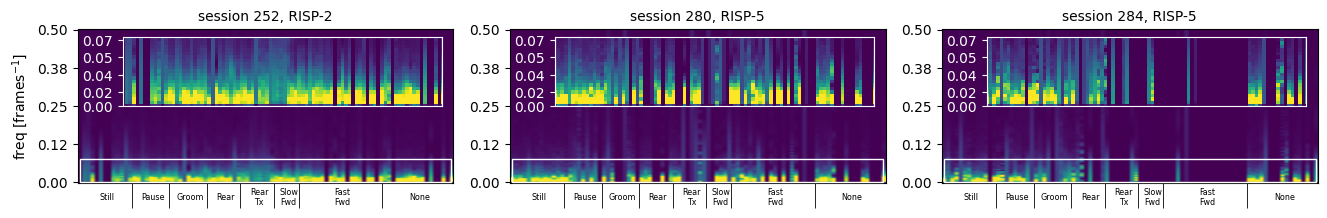

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


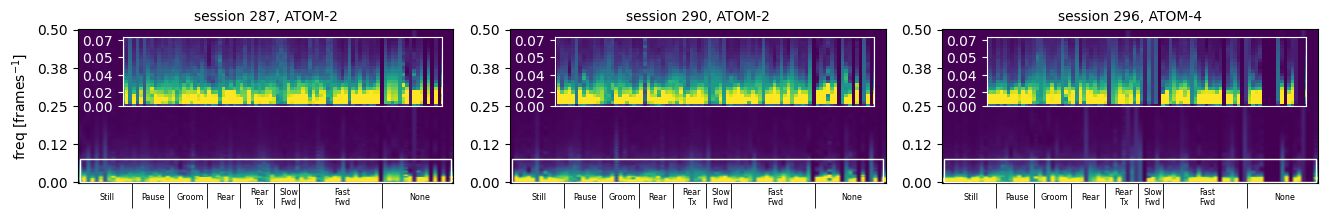

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


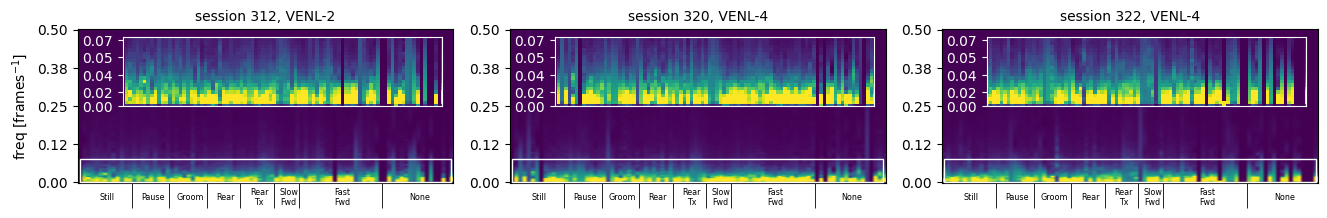

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


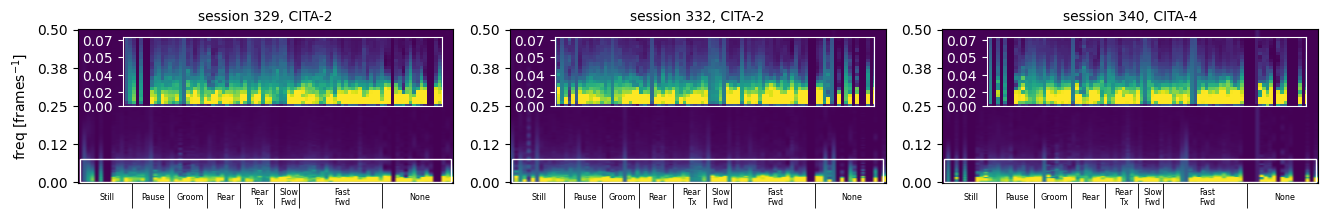

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


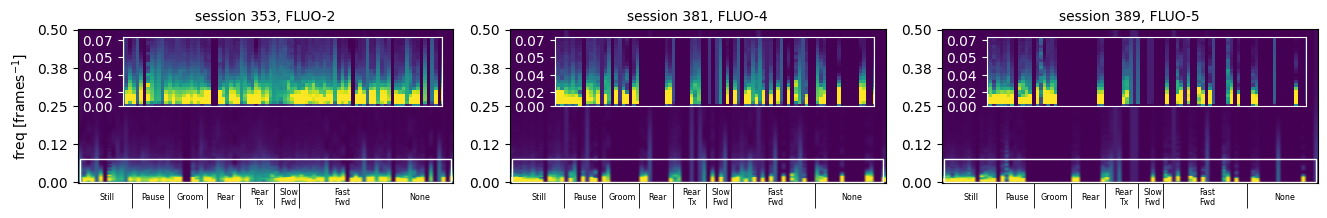

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


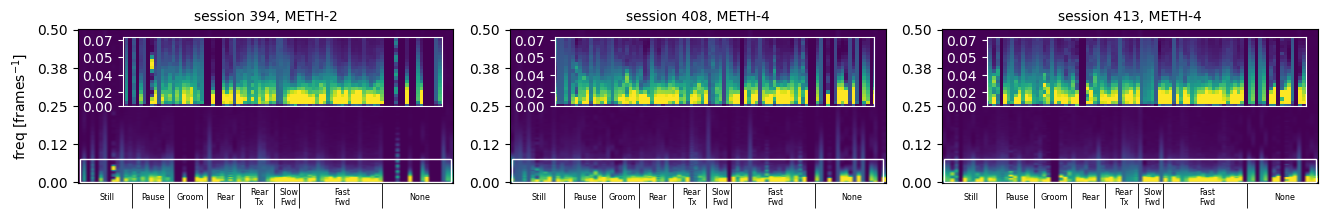

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


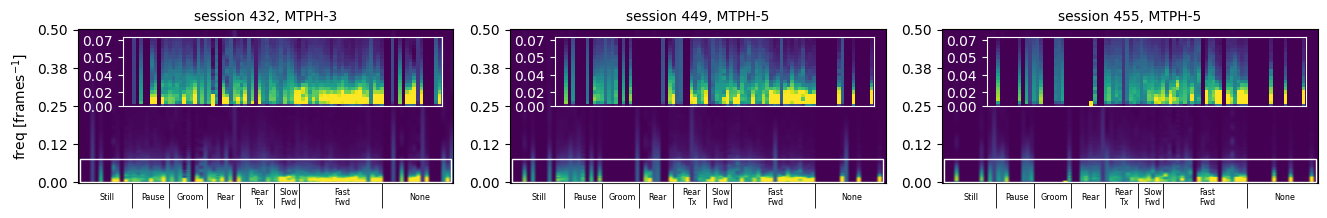

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


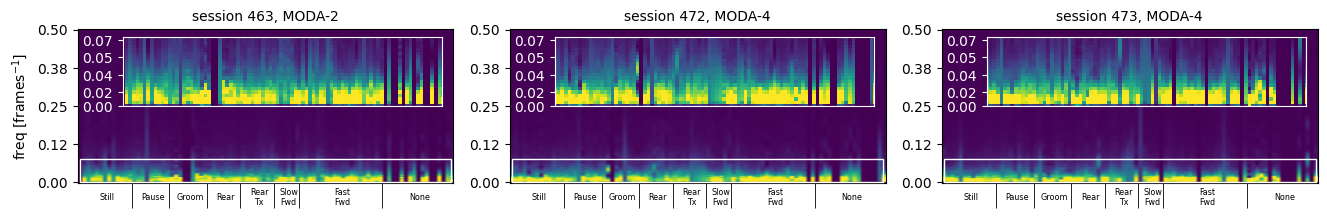

/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
/tmp/ipykernel_756/699651571.py:26: RuntimeWarning: invalid value encountered in divide
  pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized


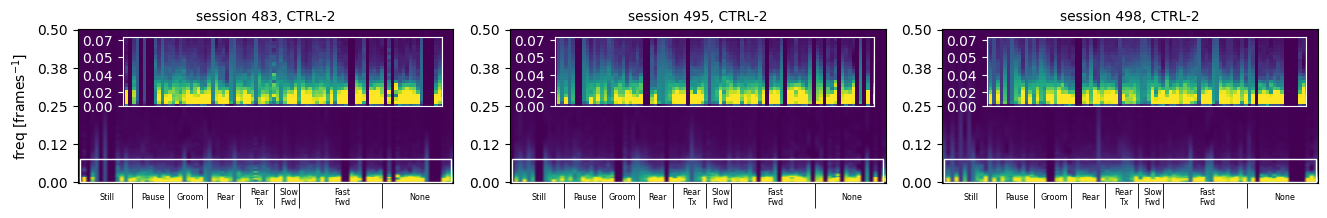

In [73]:
lag_size_min = 5
lag_size_fps = lag_size_min * 60 * 30  # x-axis tick freqeucny

n_examples_per_drug = 3
for start_idx, this_n in zip(idxs, n_per_drug):
    this_key = jr.fold_in(jr.key(0), start_idx)
    selected_sessions = jr.choice(
        this_key, this_n, shape=(n_examples_per_drug,), replace=False,
    )
    selected_sessions = jnp.sort(selected_sessions)
    selected_sessions += start_idx

    fig, axs = plt.subplots(
        ncols=n_examples_per_drug, sharey=False,
        gridspec_kw={'wspace': 0.15},
        figsize=(16,2),
    )

    for ax, i_session in zip(axs, selected_sessions):
        f, pxx = sp.signal.welch(np.asarray(onehot_syllables[i_session]), axis=0)

        mat = jnp.where(
            pxx.sum(axis=0, keepdims=True) > 0,
            pxx / pxx.sum(axis=0, keepdims=True),  # normalize such PSD for each syllable is normalized
            0
        )

        # Plot full image
        vmax = 0.10 # vmax = np.percentile(mat, 99)
        im = ax.imshow(mat, aspect='auto', clim=(0,vmax), origin='lower')
        # plt.colorbar(im, ax=ax, extend='max')

        # x-axis
        set_syllable_cluster_ticks(ax, axis='x')

        # y-axis
        yticks = np.linspace(0, len(f)-1, num=5, dtype=int)
        yticklabels = [f"{f[int(y)]:.2f}" for y in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

        # plot inset
        ylim = 20
        yticks = np.linspace(0, ylim-1, num=5, dtype=int)
        yticklabels = [f"{f[int(y)]:.2f}" for y in yticks]
        axins = ax.inset_axes(
            [0.12, 0.5, 0.85, 0.45],  # (left, bottom, width, height)
            xlim=(0, n_syllables-1), ylim=(0,ylim), 
            xticklabels=[], yticks=yticks, yticklabels=yticklabels,
        )
        axins.tick_params(colors='white')
        axins.tick_params(axis='x', bottom=False)
        axins.spines[['left','right','top','bottom']].set_color('white')

        axins.imshow(mat, aspect='auto', clim=(0,vmax), origin="lower")

        ax.indicate_inset_zoom(axins, edgecolor="white", linewidth=1, alpha=1, zorder=3)

        ax.set_title(f"session {i_session}, {session_names[i_session]}", fontsize='medium')

    axs[0].set_ylabel(r"freq [frames$^{-1}$]");
    plt.show()

There are no PSD peaks in the higher frequency, suggesting that most syllable dynamics are fairly slow timescale. This is promising, because then we may not have conflicting constraints between setting a bin width small enough to capture faster timescale dynamics and setting a bin width large enough to achieve statistical power.

**PSD aggregated over all sessions**

In [41]:
# PSD, units [V**2/Hz].
pxxs = []
for tmp in onehot_syllables:
    f, pxx = sp.signal.welch(tmp, axis=0)
    pxxs.append(pxx)

pxxs = np.asarray(pxxs)
print(f'{pxxs.shape=}')

# Normalize PSD such that power spectrum of each syllable sums to 1
pxx_flat = np.where(
    pxxs.sum(axis=1, keepdims=True) > 0,
    pxxs / pxxs.sum(axis=1, keepdims=True),
    0
)

# Flattent PSDs along sessions and syllables. shape (n_sessions x n_syllables, n_freq_bins)
pxx_flat = np.transpose(pxx_flat, axes=(0,2,1)).reshape(-1, len(f),)
print(f'After flattening: {pxx_flat.shape=}')

# Remove instances that have no power (e.g. the syllable was never used in a session)
pxx_flat = pxx_flat[pxx_flat.sum(axis=-1)>0]
print(f'After removing empty instances: {pxx_flat.shape=}')

# Normalize
pxx_flat = pxx_flat.sum(axis=0) / pxx_flat.sum()

pxxs.shape=(501, 129, 90)
After flattening: pxx_flat.shape=(45090, 129)
After removing empty instances: pxx_flat.shape=(37140, 129)


/tmp/ipykernel_20614/4225081502.py:13: RuntimeWarning: invalid value encountered in divide
  pxxs / pxxs.sum(axis=1, keepdims=True),


In [126]:
i_max = np.argmax(pxx_flat)
print(f"Modal frequency = {f[i_max]:.3f} frames^-1 => {1/f[i_max]:.0f} frames = {1/f[i_max] / 30:.1f} s")

half_max = 0.5 * pxx_flat.max()
i_half_max = np.argmin(np.abs(pxx_flat - half_max))
print(f"Half-max frequency = {f[i_half_max]:.3f} frsames^-1 => {1/f[i_half_max]:.0f} frames = {1/f[i_half_max] / 30:.1f} s")

i_90 = np.argmin(np.abs(0.90 - np.cumsum(pxx_flat)))
print(f"90% power explained = {f[i_90]:.3f} frames^-1 => {1/f[i_90]:.0f} frames = {1/f[i_90] / 30:.1f} s")

Modal frequency = 0.008 frames^-1 => 128 frames = 4.3 s
Half-max frequency = 0.023 frames^-1 => 43 frames = 1.4 s
66% power explained = 0.035 frames^-1 => 28 frames = 0.9 s


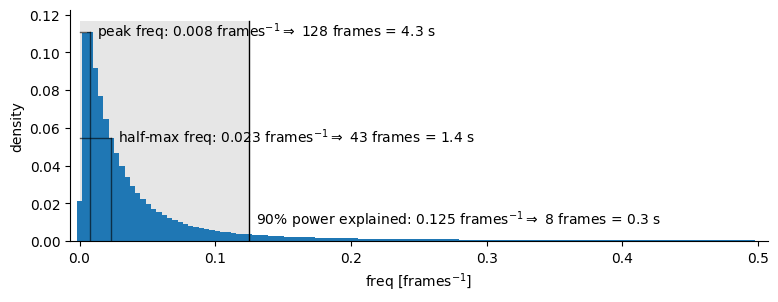

In [139]:
def crosshair_annotate(ax, x, y, label=None):
    ax.plot([x,x], [0,y], **crosshair_kw)
    ax.plot([0, x], [y,y], c='k', lw=1, alpha=0.6)

    if label is not None:
        ax.annotate(label, (x,y), xytext=(5,0), textcoords="offset points", va='center')

# ---------------------------------------------------------------------------------------------

plt.figure(figsize=(9,3))

ax = plt.gca()

df = (f[1:] - f[:-1]).mean()
ax.bar(f, pxx_flat, width=df)
ax.margins(x=0.01)

ax.set_xlabel(r"freq [frames$^{-1}$]")

# Add x-axis with freq in units of [ms^-1]
def freq_frames_to_ms(x, pos):
    """Convert 1/frames to 1/ms."""
    return f"{x/30*100:.1f}"

# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.xaxis.set_major_formatter(freq_frames_to_ms)
# ax2.set_xlabel(r"freq [ms$^{-1}$]")

# y-axis
ax.set_ylabel('density')

fmt = lambda x, y: f"{x:.3f} " + r"frames$^{-1}$"
crosshair_kw = dict(c='k', lw=1, alpha=0.6)

# Frequency at max power density 
f_max = f[i_max]
crosshair_annotate(
    ax, f[i_max], pxx_flat[i_max],
    label=f"peak freq: {f_max:.3f} " + r"frames$^{-1} \Rightarrow$ " + f"{1/f_max:.0f} frames = {1/f_max/30:.1f} s"
)

# Frequency at half max power density -- not exactly clear on the meaning of this variable
f_half_max = f[i_half_max]
crosshair_annotate(
    ax, f[i_half_max], pxx_flat[i_half_max],
    label=f"half-max freq: {f_half_max:.3f} " + r"frames$^{-1} \Rightarrow$ " + f"{1/f_half_max:.0f} frames = {1/f_half_max/30:.1f} s"
)

f_90 = f[i_90]
ylim = ax.get_ylim()[1]
ax.plot([f[i_90], f[i_90]], [0, ylim], color='k', lw=1)
ax.fill_betweenx([0,ylim], [f[i_90], f[i_90]], 0, zorder=0, fc='0.9')
ax.annotate(
    f"90% power explained: {f_90:.3f} " + r"frames$^{-1} \Rightarrow$ " + f"{1/f_90:.0f} frames = {1/f_90/30:.1f} s",
    (f[i_90],0.10*ylim), xytext=(5,0), textcoords="offset points", va='center'
)
sns.despine()

90% of the power occurs at 8 frames (300 ms) or slower. The modal correlation across all sessions and syllables is 128 frames or 4.3 s.

This analysis suggests that we do not have to worry about "missing out" on super high frequency syllable dynamics.

This analysis, however, may be somewhat biased by the fact that the "slow" timescale syllables are used more frequently.

Interestingly, this analysis does not seem to place as much density on "super" slow timescales -- in the cross-correlational plots, we saw correlation even on the scale of 5 - 10 minutes. Why is this anlaysis not really picking up on that? Should I be sliding/increasing the gap?

### 1d. Transition matrix mixing time

In [8]:
def sample_transition_matrix(seed, params, samples):

    state = samples['pose_state']   # shape (N,)

    N, S = len(state), len(params['state_transition_count'])

    def count_all(t, counts):
        return counts.at[state[t], state[t+1]].add(1)

    counts = lax.fori_loop(0, N-1, count_all, jnp.zeros((S, S)))

In [9]:
def count_transitions(state_sequence, n_states):
    """Count transitions between states in a given sequence.
    
    Parameters
        state_sequence: int array, shape (sequence_length,)
            Sequence of state ids, with values between [0, n_states).
        n_states: int.
            Total number of states
    
    Returns
        transition_mat: int array, shape (n_states, n_states)
            Entry (i,j) corresponds to the number of times that state i
            transitioned to state j in the state sequence.
    """

    def _count(tx_mat, inpt):
        s_t, s_tp1 = inpt
        tx_mat = tx_mat.at[s_t, s_tp1].add(1)
        return tx_mat, None

    transition_mat, _ = lax.scan(
        _count,
        jnp.zeros((n_states, n_states), dtype=int),
        (state_sequence[:-1], state_sequence[1:]),
    )

    return transition_mat

In [10]:
def count_transitions_sliding_window(state_sequence, n_states, window_size, stride=None):
    """Count transitions between states of a sequence in a sliding window fashion.

    Parameters
        state_sequence: int array, shape (sequence_length,)
            Sequence of state ids, with values between [0, n_states).
        n_states: int.
            Total number of states
        window_size: int
            Window width to compute transitions over
        stride: int or None
            Number of steps between successive windows. Stride should be between
            1 (rolling window) and `window_size` (non-overlapping windows), inclusive.
            If None, defaults to `window_size`.

    Returns
        transition_mats: in array, shape (n_windows, n_states, n_states)
            `n_windows = ceil((sequence_length - window_size + 1) / stride)`,
    """
    
    if stride is None:
        stride = window_size
        
    starts = jnp.arange(0, len(state_sequence) - window_size + 1, stride)
    
    transition_mats = vmap(lambda start: count_transitions(
        lax.dynamic_slice(state_sequence, (start,), (window_size,)),
        n_states
    ))(starts)

    return transition_mats

**Single window size, no overlap**

In [17]:
# For a given window, this expression will compute transition counts for all sessions
period = 2  # minutes
window_size = period * 60 * 30
transition_counts = vmap(
    count_transitions_sliding_window, in_axes=(0,None,None)
)(session_syllables, n_syllables+1, window_size)

# Omit truncated syllables
transition_counts = transition_counts[..., :-1, :-1]

# Convert to transition probability matrix
# For states with no observations, replace with uniform probabiltiy
row_sums = transition_counts.sum(axis=-1, keepdims=True)
transition_probs = jnp.where(
    row_sums > 0, transition_counts / row_sums, jnp.ones(n_syllables) / n_syllables,
)

# Estimate mixing time from the spectral gap.
# Ignore complex part of eigenvalues...
eigvals = vmap(jnp.linalg.eigvals)(transition_probs.reshape(-1, n_syllables, n_syllables))
eigval_2 = jnp.max(jnp.where(eigvals < 1, eigvals, 0), axis=-1)

mixing_times = 1 / (1 - eigval_2.real)

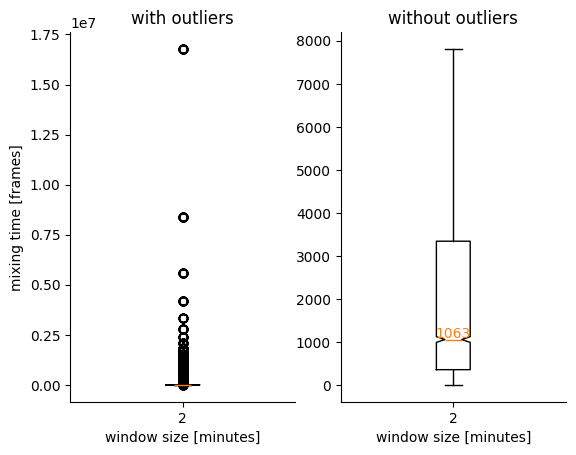

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2)

# Show with outliers
ax = axs[0]
ax.boxplot(mixing_times, notch=True, showfliers=True)
ax.set_xticklabels([period])
ax.set_xlabel("window size [minutes]")
ax.set_title("with outliers")

ax.set_ylabel("mixing time [frames]")

# Show without outliers
ax = axs[1]
ax.boxplot(mixing_times, notch=True, showfliers=False)

mdn = jnp.median(mixing_times)
ax.annotate(
    int(mdn), (1, mdn),
    xytext=(0,1), textcoords='offset points',
    ha='center', color='C1'
)

ax.set_xticklabels([period])
ax.set_xlabel("window size [minutes]")
ax.set_title("without outliers")
sns.despine()

**Window size sweep, 50% overlap**

In [33]:
# For a given window, this expression will compute transition counts for all sessions
periods = jnp.array([0.5, 1, 2, 5, 10])  # minutes

mixing_times = []
for period in periods:
    
    window_size = int(period * 60 * 30)
    stride = int(window_size * 0.5)

    transition_counts = vmap(
        count_transitions_sliding_window, in_axes=(0,None,None)
    )(session_syllables, n_syllables+1, window_size)

    # Omit truncated syllables
    transition_counts = transition_counts[..., :-1, :-1]

    # Convert to transition probability matrix
    # For states with no observations, replace with uniform probabiltiy
    row_sums = transition_counts.sum(axis=-1, keepdims=True)
    transition_probs = jnp.where(
        row_sums > 0, transition_counts / row_sums, jnp.ones(n_syllables) / n_syllables,
    )

    # Estimate mixing time from the spectral gap.
    # Ignore complex part of eigenvalues...
    eigvals = vmap(jnp.linalg.eigvals)(transition_probs.reshape(-1, n_syllables, n_syllables))
    eigval_2 = jnp.max(jnp.where(eigvals < 1, eigvals, 0), axis=-1)

    mixing_times.append(1 / (1 - eigval_2.real))

median_times = jnp.array([jnp.median(vec) for vec in mixing_times])

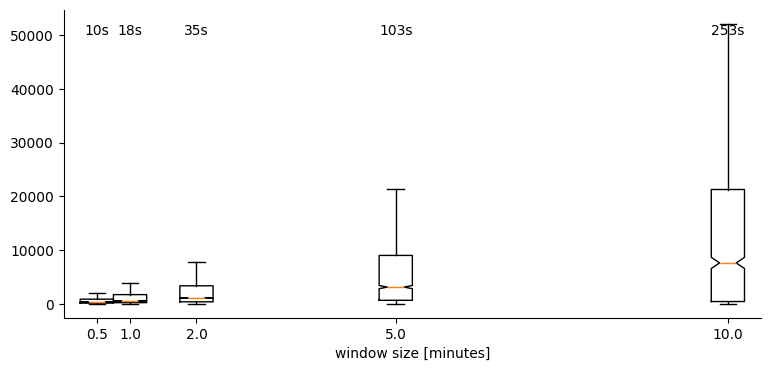

In [55]:
plt.figure(figsize=(9,4))

ax=plt.gca()

ax.boxplot(mixing_times, positions=periods, showfliers=False, notch=True)

ax.set_xlabel("window size [minutes]")

for period, mdn in zip(periods, median_times):
    ax.annotate(f"{int(mdn/30)}s", (period, 50000), ha='center')
    
sns.despine()

Results are inconclusive.